In [2]:
# DeBERTa-v3-small Notebook
# 1. Install and import dependencies
!pip install transformers datasets
import pandas as pd, numpy as np, torch, random, re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding
from torch.optim import AdamW
from torch.optim.swa_utils import AveragedModel, SWALR
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 2. Load dataset
train_df = pd.read_csv('/content/Constraint_Train.csv')
val_df = pd.read_csv('/content/Constraint_Val.csv')

In [5]:
# 3. Label encode
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
val_df['label_encoded'] = le.transform(val_df['label'])

In [6]:
# 4. Synonym Replacement Augmentation
def synonym_replacement(text, n=1):
  words = re.findall(r'\w+', text)
  new_words = words.copy()
  random.shuffle(words)
  for word in words:
    synonyms = wordnet.synsets(word)
    if synonyms:
      synonym_list = list(set([lemma.name().replace('_', ' ') for s in synonyms for lemma in s.lemmas() if lemma.name() != word]))
      if synonym_list:
        new_words = [random.choice(synonym_list) if w == word else w for w in new_words]
        break
  return ' '.join(new_words)

In [7]:
augmented_texts, augmented_labels = [], []

for i in range(len(train_df)):
    if random.random() < 0.3:
        augmented_texts.append(synonym_replacement(train_df.iloc[i]['tweet']))
        augmented_labels.append(train_df.iloc[i]['label_encoded'])

aug_df = pd.DataFrame({'tweet': augmented_texts, 'label_encoded': augmented_labels})
train_df = pd.concat([train_df[['tweet', 'label_encoded']], aug_df], ignore_index=True)


In [8]:
# 5. Dataset
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [9]:
# 6. Tokenizer and Dataloaders
model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataset = NewsDataset(
    train_df['tweet'].tolist(),
    train_df['label_encoded'].tolist(),
    tokenizer
)

val_dataset = NewsDataset(
    val_df['tweet'].tolist(),
    val_df['label_encoded'].tolist(),
    tokenizer
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    collate_fn=data_collator
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [10]:
# 7. Model and Optimizer Setup
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

lr = 2e-5
optimizer = AdamW(model.parameters(), lr=lr)

total_steps = len(train_dataloader) * 10
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

swa_model = AveragedModel(model)
swa_scheduler = SWALR(optimizer, swa_lr=1e-5)


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# 8. Training
best_acc = 0

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    model.eval()
    preds, labels = [], []

    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            out = model(**batch)
            preds += torch.argmax(out.logits, axis=1).cpu().tolist()
            labels += batch['labels'].cpu().tolist()

    acc = accuracy_score(labels, preds)
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}, F1 SCORE: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "deberta_best.pt")

    if epoch >= 6:
        swa_model.update_parameters(model)
        swa_scheduler.step()

print("Best DeBERTa Accuracy:", best_acc)



Epoch 1: 100%|██████████| 521/521 [02:06<00:00,  4.13it/s]


Epoch 1 - Loss: 102.2973, F1 SCORE: 0.9668


Epoch 2: 100%|██████████| 521/521 [02:08<00:00,  4.05it/s]


Epoch 2 - Loss: 31.3879, F1 SCORE: 0.9701


Epoch 3: 100%|██████████| 521/521 [02:08<00:00,  4.04it/s]


Epoch 3 - Loss: 13.5243, F1 SCORE: 0.9720


Epoch 4: 100%|██████████| 521/521 [02:08<00:00,  4.04it/s]


Epoch 4 - Loss: 7.6350, F1 SCORE: 0.9762


Epoch 5: 100%|██████████| 521/521 [02:08<00:00,  4.05it/s]


Epoch 5 - Loss: 3.6427, F1 SCORE: 0.9785


Epoch 6: 100%|██████████| 521/521 [02:08<00:00,  4.06it/s]


Epoch 6 - Loss: 3.7576, F1 SCORE: 0.9710


Epoch 7: 100%|██████████| 521/521 [02:07<00:00,  4.08it/s]


Epoch 7 - Loss: 2.1331, F1 SCORE: 0.9729


Epoch 8: 100%|██████████| 521/521 [02:07<00:00,  4.07it/s]


Epoch 8 - Loss: 1.5416, F1 SCORE: 0.9752


Epoch 9: 100%|██████████| 521/521 [02:08<00:00,  4.07it/s]


Epoch 9 - Loss: 1.3186, F1 SCORE: 0.9701


Epoch 10: 100%|██████████| 521/521 [02:07<00:00,  4.07it/s]


Epoch 10 - Loss: 1.2038, F1 SCORE: 0.9757
Best DeBERTa Accuracy: 0.9785046728971962


In [17]:
def predict_news(text):
    """
    Predict whether a given text is real or fake news.

    Args:
        text (str): The text to classify

    Returns:
        dict: A dictionary containing the prediction ('real' or 'fake') and the confidence scores
    """
    # Load the best model if not already loaded
    if not hasattr(predict_news, 'model_loaded'):
        model.load_state_dict(torch.load("deberta_best.pt", map_location=device))
        model.eval()
        predict_news.model_loaded = True

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get probabilities using softmax
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    probs = probs.cpu().numpy()[0]

    # Get the predicted label
    predicted_label_idx = torch.argmax(outputs.logits).item()

    # Get the original class names from the LabelEncoder
    class_names = le.classes_

    # Create confidence dictionary with proper class names
    confidence = {class_names[i]: float(probs[i]) for i in range(len(class_names))}

    # Determine the predicted class
    predicted_class = class_names[predicted_label_idx]

    return {
        'prediction': predicted_class,
        'confidence': confidence
    }

In [18]:
prediction = predict_news("India records yet another single-day rise of over 28000 new cases while more than 5.5 lakh individuals have recovered from COVID-19. Kerala government sets up its first plasma bank in the state following in the steps of Delhi and West Bengal. #COVID19 #CoronavirusFacts https://t.co/JhSQUqMvta")
print(prediction)

{'prediction': 'fake', 'confidence': {'fake': 0.9999793767929077, 'real': 2.0589308405760676e-05}}


In [19]:
prediction = predict_news("Last note: Washington DC's total test count fell by ~22% presumably pulling out antibody tests.")
print(prediction)

{'prediction': 'real', 'confidence': {'fake': 0.0004962331149727106, 'real': 0.9995037317276001}}


INPUT TEXT: India records yet another single-day rise of over 28000 new cases while more than 5.5 lakh individuals have recovered from COVID-19. Kerala government sets up its first plasma bank in the state follow...

PREDICTION RESULT:
- Predicted class: fake
- Confidence: 100.00%
- All probabilities: {'fake': np.float32(0.9999794), 'real': np.float32(2.0589308e-05)}

LIME EXPLANATION:

Features supporting FAKE classification:
  COVID                +0.0666
  CoronavirusFacts     +0.0636
  JhSQUqMvta           -0.0494
  single               +0.0362
  government           +0.0359
  India                +0.0284
  plasma               +0.0250
  West                 -0.0246
  following            -0.0208
  Bengal               +0.0133

Features supporting REAL classification:
  COVID                -0.0666
  CoronavirusFacts     -0.0636
  JhSQUqMvta           +0.0494
  single               -0.0362
  government           -0.0359
  India                -0.0284
  plasma               -0.0250


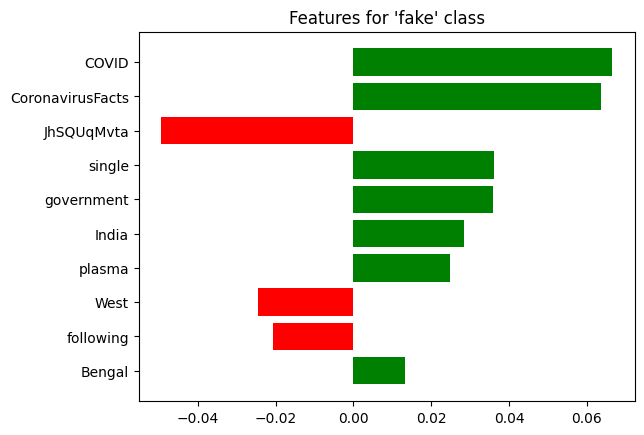

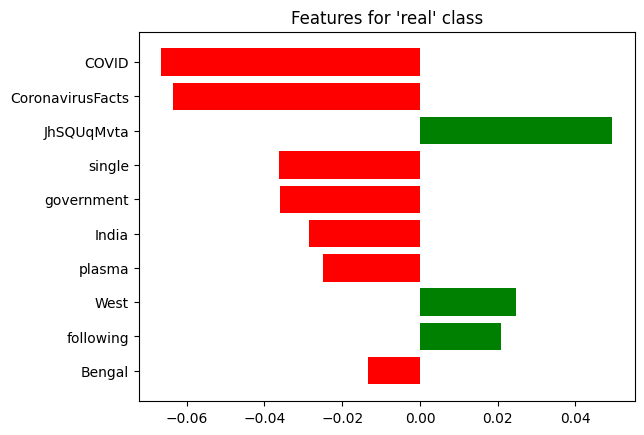

In [30]:
def predict_with_explanation(text, num_features=10):
    """
    Predict and explain the classification of news text

    Args:
        text (str): The text to analyze
        num_features (int): Number of features to show in explanation

    Returns:
        dict: Prediction results and explanation
    """
    # Ensure model is loaded
    if not hasattr(predict_with_explanation, 'model_loaded'):
        model.load_state_dict(torch.load("deberta_best.pt", map_location=device))
        model.eval()
        predict_with_explanation.model_loaded = True

    # Get prediction probabilities
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    pred_class = le.classes_[probs.argmax()]

    # LIME explanation
    explainer = LimeTextExplainer(class_names=le.classes_)

    def predictor(texts):
        inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True,
                         max_length=128, add_special_tokens=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    exp = explainer.explain_instance(text, predictor, num_features=num_features, num_samples=500, top_labels=len(le.classes_))

    # Get available labels from the explanation
    available_labels = exp.available_labels()

    # Prepare explanation data
    explanation = {}
    for label in available_labels:
        explanation[le.classes_[label]] = exp.as_list(label=label)

    # Print results
    print("="*50)
    print(f"INPUT TEXT: {text[:200]}...\n" if len(text) > 200 else f"INPUT TEXT: {text}\n")
    print("PREDICTION RESULT:")
    print(f"- Predicted class: {pred_class}")
    print(f"- Confidence: {max(probs):.2%}")
    print(f"- All probabilities: {dict(zip(le.classes_, probs))}\n")

    print("LIME EXPLANATION:")
    for class_name in le.classes_:
        if class_name in explanation:
            print(f"\nFeatures supporting {class_name.upper()} classification:")
            for feature, weight in explanation[class_name]:
                print(f"  {feature:20} {weight:+.4f}")

    # Visualizations
    print("\nVISUALIZATION:")
    for label in available_labels:
        fig = exp.as_pyplot_figure(label)
        plt.title(f"Features for '{le.classes_[label]}' class")
        plt.show()

    return {
        'prediction': pred_class,
        'confidence': max(probs),
        'probabilities': dict(zip(le.classes_, probs)),
        'explanation': explanation
    }

# Example usage
sample_text = "India records yet another single-day rise of over 28000 new cases while more than 5.5 lakh individuals have recovered from COVID-19. Kerala government sets up its first plasma bank in the state following in the steps of Delhi and West Bengal. #COVID19 #CoronavirusFacts https://t.co/JhSQUqMvta"
result = predict_with_explanation(sample_text)

In [31]:
# creating a web app
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00


In [32]:
%%writefile app.py
# app.py
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Set up the app
st.set_page_config(page_title="Fake News Detector", layout="wide")
st.title("🔍 Fake News Detection with Explainable AI")

# Load model and tokenizer
@st.cache_resource
def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "microsoft/deberta-v3-small"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    # Load your trained weights (replace with your actual path)
    model.load_state_dict(torch.load("deberta_best.pt", map_location=device))
    model.eval()

    # Create dummy LabelEncoder (replace with your actual classes)
    le = LabelEncoder()
    le.classes_ = np.array(['fake', 'real'])  # Replace with your actual classes

    return model, tokenizer, le, device

model, tokenizer, le, device = load_model()

# Prediction function
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
    return probs

# Explanation function
def explain_prediction(text, num_features=10):
    explainer = LimeTextExplainer(class_names=le.classes_)

    def predictor(texts):
        inputs = tokenizer(texts, return_tensors="pt", truncation=True,
                         padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    exp = explainer.explain_instance(text, predictor, num_features=num_features, num_samples=500)
    return exp

# Main app interface
with st.form("news_form"):
    news_text = st.text_area("Enter news text to analyze:",
                           "India records yet another single-day rise of over 28000 new cases...")
    submitted = st.form_submit_button("Analyze")

if submitted and news_text:
    with st.spinner("Analyzing text..."):
        # Make prediction
        probs = predict(news_text)
        pred_class = le.classes_[np.argmax(probs)]
        confidence = np.max(probs)

        # Display results
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Prediction Results")
            st.metric("Prediction", pred_class, f"{confidence:.1%} confidence")

            # Probability bars
            st.write("Class Probabilities:")
            for i, class_name in enumerate(le.classes_):
                st.progress(probs[i], text=f"{class_name}: {probs[i]:.1%}")

        with col2:
            st.subheader("Model Explanation")
            exp = explain_prediction(news_text)

            # Show explanation for each class
            tabs = st.tabs([f"Features for '{cls}'" for cls in le.classes_])

            for i, tab in enumerate(tabs):
                with tab:
                    # Get explanation for this class
                    weights = exp.as_list(label=i)

                    # Create a bar chart
                    features, scores = zip(*weights)
                    colors = ['green' if score > 0 else 'red' for score in scores]

                    fig, ax = plt.subplots(figsize=(8, 4))
                    ax.barh(features, scores, color=colors)
                    ax.set_title(f"Features contributing to '{le.classes_[i]}'")
                    ax.set_xlabel("Contribution strength")
                    st.pyplot(fig)

                    # Show raw data
                    with st.expander("See detailed weights"):
                        for feature, score in weights:
                            st.write(f"{feature}: {score:+.4f}")

        # Show full text being analyzed
        st.subheader("Analyzed Text")
        st.text(news_text)

# Add some instructions
st.sidebar.markdown("""
### How to Use This App
1. Enter news text in the text box
2. Click "Analyze" button
3. View prediction results and explanation

### Understanding the Results
- **Prediction**: The model's classification (real/fake)
- **Confidence**: How certain the model is
- **Explanation**: Which words influenced the decision
  - Green bars: Support the class
  - Red bars: Oppose the class
""")

Writing app.py


In [33]:
pip install streamlit transformers lime matplotlib torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [37]:
!pip install streamlit jupyter-server-proxy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.16.0
    Uninstalling jupyter-server-1.16.0:
      Successfully uninstalled jupyter-server-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.3 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2.0, but you have jupyter-client 8.6.3 whic

In [41]:
from google.colab import files
files.download('deberta_best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>